In [1]:
%load_ext autoreload
%matplotlib inline

# Isolation Forest pipeline with segment anomaly scores

This notebook builds further on 180327-isolation_forest_new_evaluation working with segment anomaly scores (floats) instead of segment predictions (bools). Using segment anomaly scores, a score threshold can be varied for calculation of (precision, recall) values. 

Old segment predictions were made by manually setting a parameter k to find the k-th largest anomaly score, which was then the score threshold.

In [2]:
import os, sys
import numpy as np
import pandas as pd
import sklearn.metrics
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.anomalies
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
import pipeline.pipeline as pipeline
from anomaly_detection.factory import *
from evaluation import evaluation, segmentation
from feature_extraction import feature_extraction, preprocessing

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
df = feature_extraction.load_features_from_file(beam=1)
labels = db.query_elogbook_anomalies(beam=1)
labels_all = db.query_elogbook_no_info(beam=1)
print(len(labels), len(labels_all))

Loading file '/home/n/masters-thesis/src/../data-cern/features-b1-'.
File not found, loading '/home/n/masters-thesis/src/../data-cern/features-b1-sw_10min-2018_05_17.csv' instead.

Fetching data for pattern MKI.ELOGBOOK_tagged from 2015-06-22 00:00:00 to 2016-09-14 00:00:00

Fetching data for pattern MKI.ELOGBOOK_tagged from 2015-06-22 00:00:00 to 2016-09-14 00:00:00

23 77


## Pipeline with evaluation using PR-curve

In [4]:
anomaly_detector = "isolationforest"
detector_parameters = {
    "n_estimators": 100, 
    "max_samples": 256, 
    "n_jobs": -1, 
    "verbose": 1
}

n_estimators = 100
|| IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
        max_samples=256, n_estimators=100, n_jobs=-1, random_state=None,
        verbose=1)
|| scale_data = True


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.1s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished


|| Trained detector and scored features: 12.1 seconds
|| Created 1969 segments: 6.3 seconds
|| Created results DataFrame: 3.4 seconds


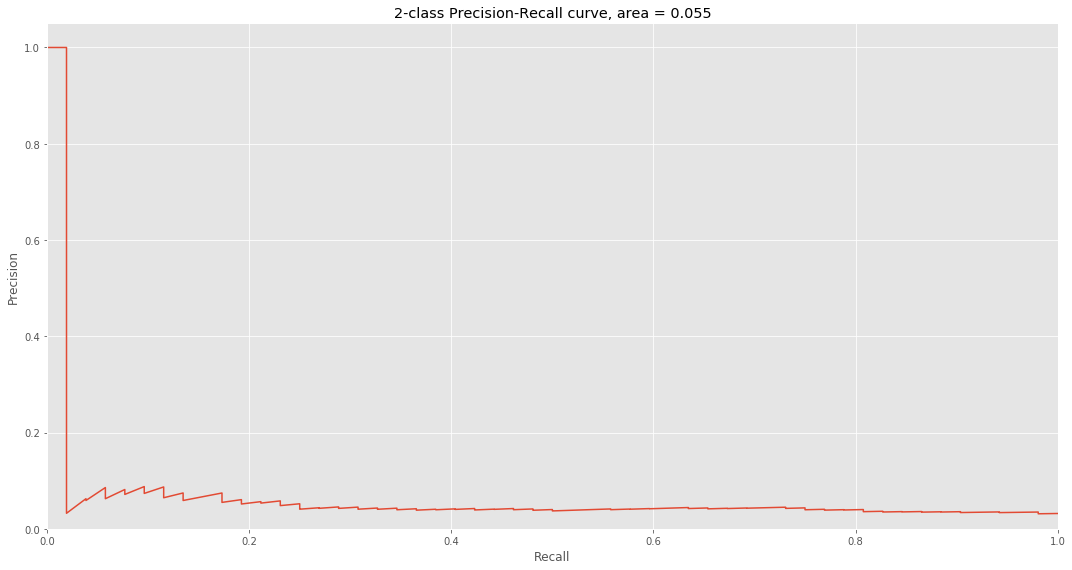

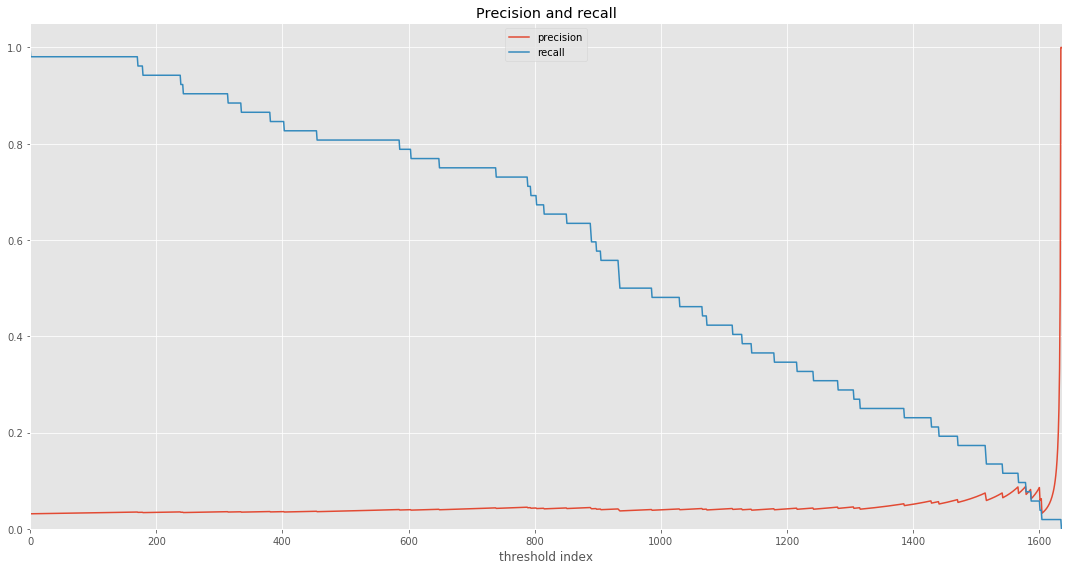

||| PR-curve tresholds: 1635, min: 0.26, max: 1.00
||| Area under PR curve = 0.05501621068180833
|| PR and Area calculation: 0.4 seconds
|| Pipeline execution time: 22.2 seconds
n_estimators = 500
|| IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
        max_samples=256, n_estimators=500, n_jobs=-1, random_state=None,
        verbose=1)
|| scale_data = True


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   10.3s remaining:   31.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   11.7s finished


|| Trained detector and scored features: 57.4 seconds
|| Created 1969 segments: 6.4 seconds
|| Created results DataFrame: 3.3 seconds


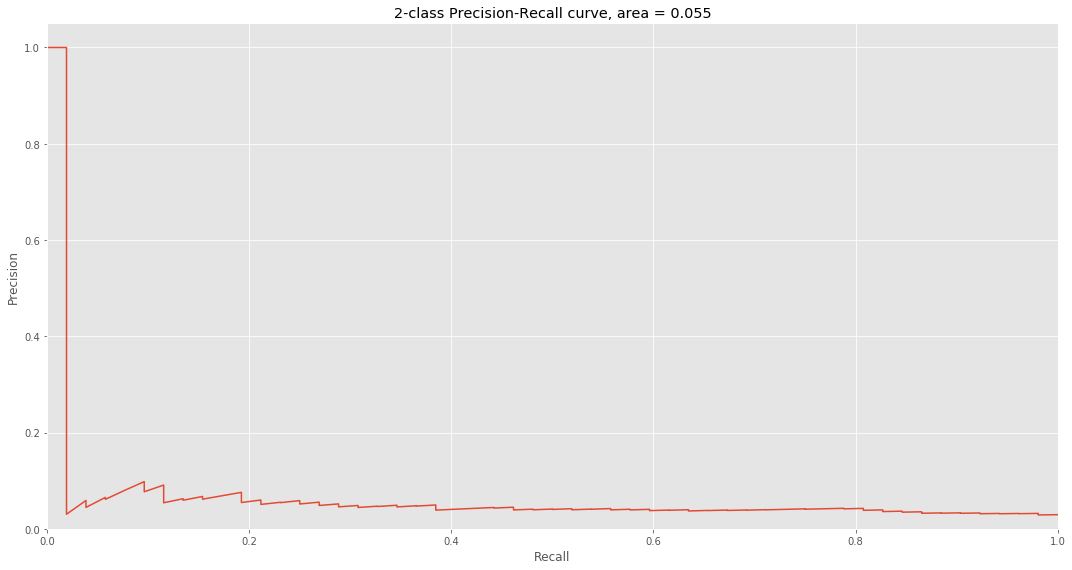

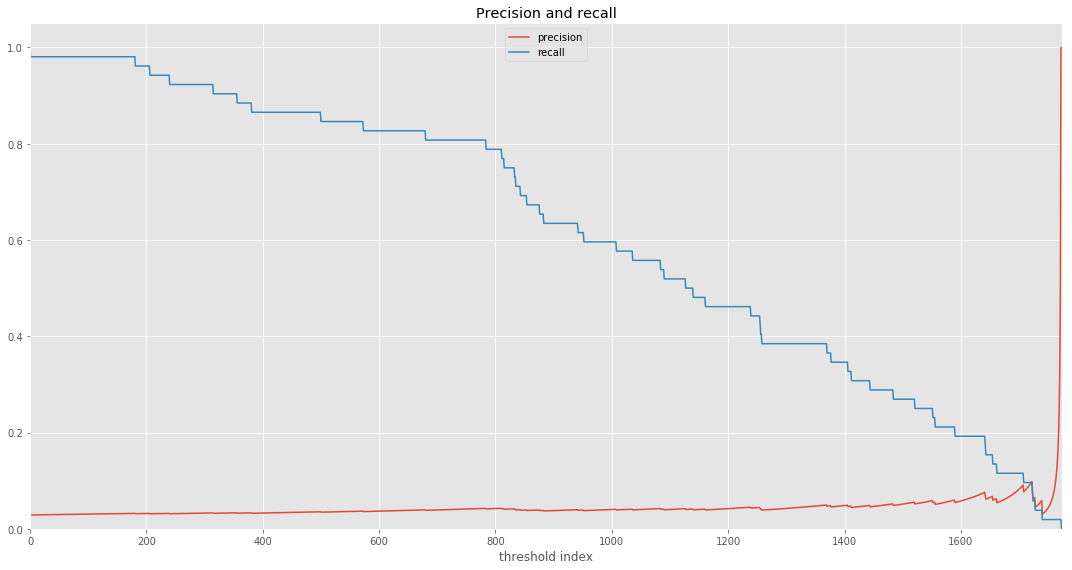

||| PR-curve tresholds: 1773, min: 0.26, max: 1.00
||| Area under PR curve = 0.055452088768736335
|| PR and Area calculation: 0.4 seconds
|| Pipeline execution time: 67.5 seconds
n_estimators = 1000
|| IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
        max_samples=256, n_estimators=1000, n_jobs=-1, random_state=None,
        verbose=1)
|| scale_data = True


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   21.9s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   23.5s finished


|| Trained detector and scored features: 115.5 seconds
|| Created 1969 segments: 6.4 seconds
|| Created results DataFrame: 3.3 seconds


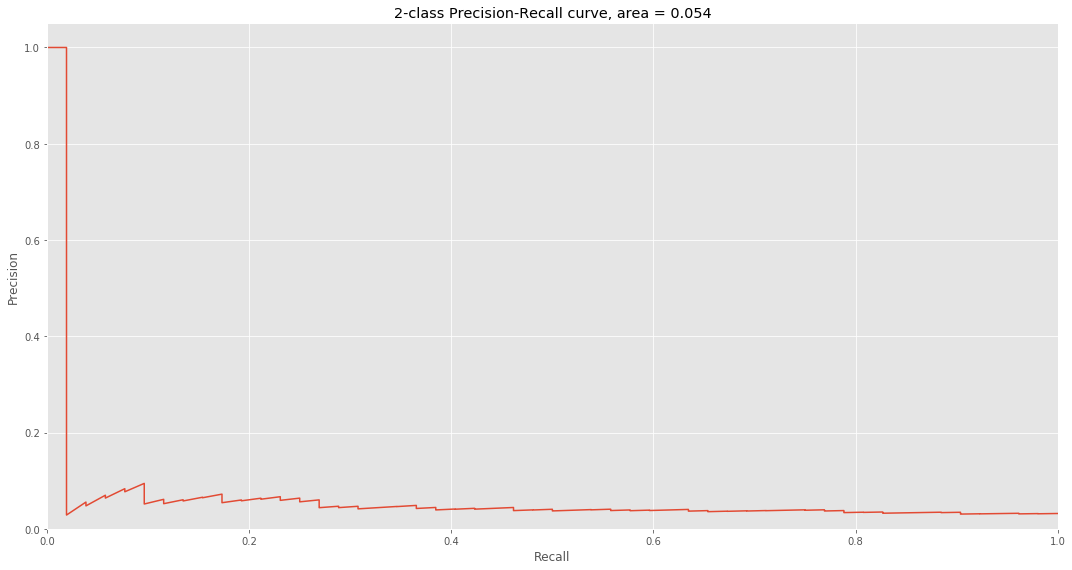

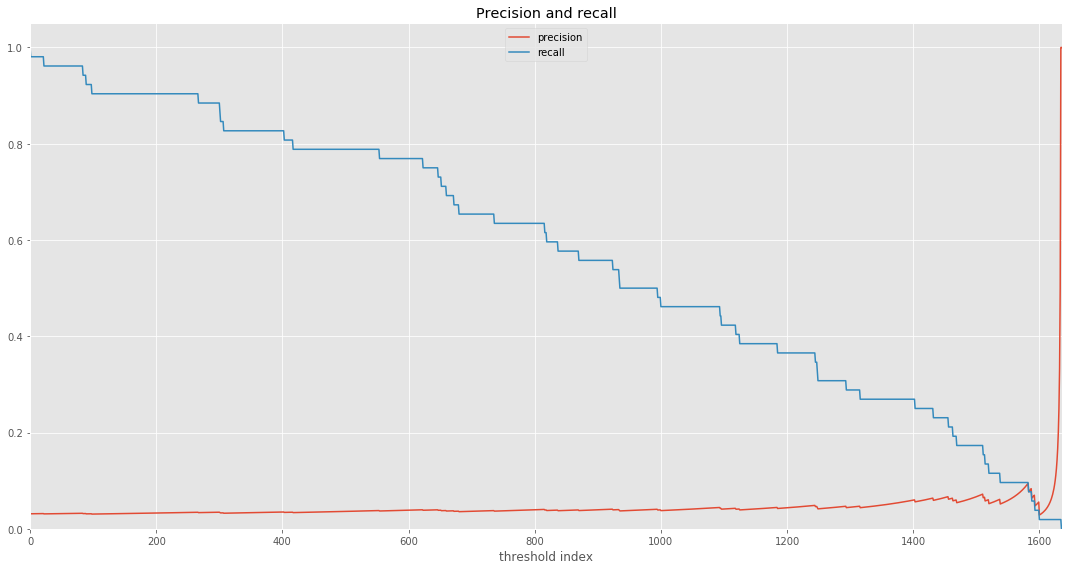

||| PR-curve tresholds: 1635, min: 0.27, max: 1.00
||| Area under PR curve = 0.05397787202209119
|| PR and Area calculation: 0.4 seconds
|| Pipeline execution time: 125.6 seconds
n_estimators = 1500
|| IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
        max_samples=256, n_estimators=1500, n_jobs=-1, random_state=None,
        verbose=1)
|| scale_data = True


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   34.1s remaining:  1.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   35.5s finished


|| Trained detector and scored features: 174.2 seconds
|| Created 1969 segments: 6.3 seconds
|| Created results DataFrame: 3.5 seconds


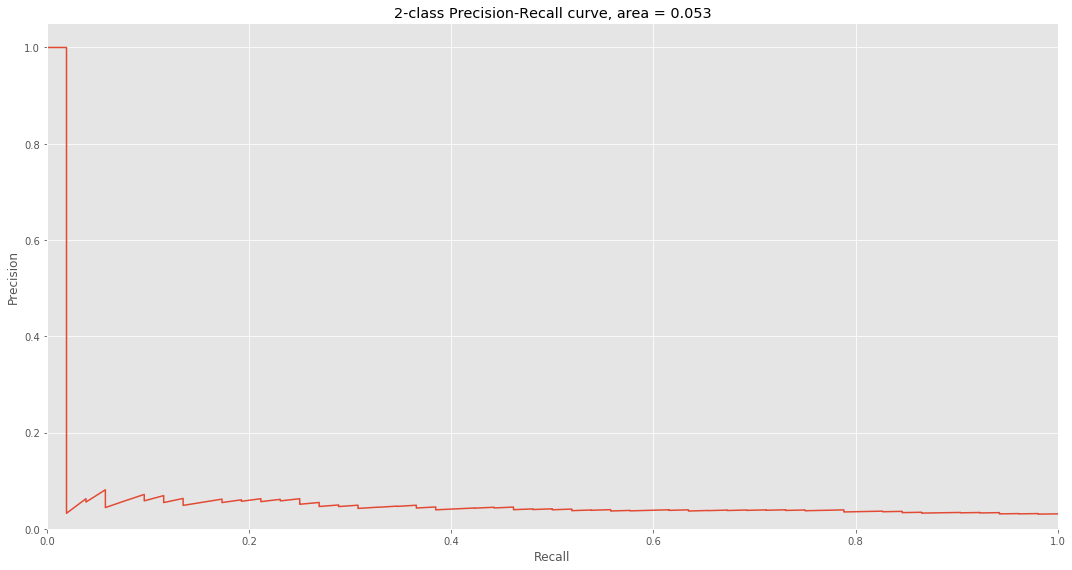

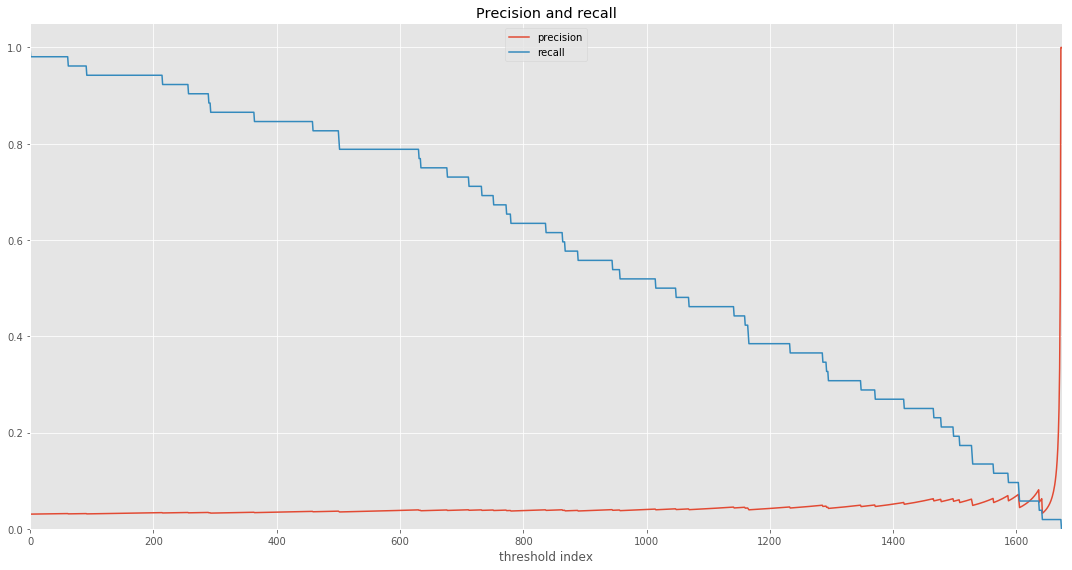

||| PR-curve tresholds: 1673, min: 0.28, max: 1.00
||| Area under PR curve = 0.052879811815433705
|| PR and Area calculation: 0.4 seconds
|| Pipeline execution time: 184.4 seconds


In [5]:
trees = [100, 500, 1000, 1500]
scores = []

for n_estimators in trees:
    print("n_estimators =", n_estimators)
    detector_parameters["n_estimators"] = n_estimators
    
    truth_and_pred_df, auc, precision, recall, thresholds, execution_time = pipeline.pipeline(
        features=df, 
        labels=labels_all, 
        anomaly_detector=anomaly_detector, 
        detector_parameters=detector_parameters,
        verbose=True
    )
    
    scores.append(auc)

## Compare to DummyDetectors

In [10]:
dummy_results = {}

|| DummyDetector(strategy='constant', constant=0.99, contamination=0.01)
|| scale_data = False
|| Trained detector and scored features: 0.0 seconds
|| Created 1969 segments: 6.3 seconds
|| Created results DataFrame: 4.1 seconds


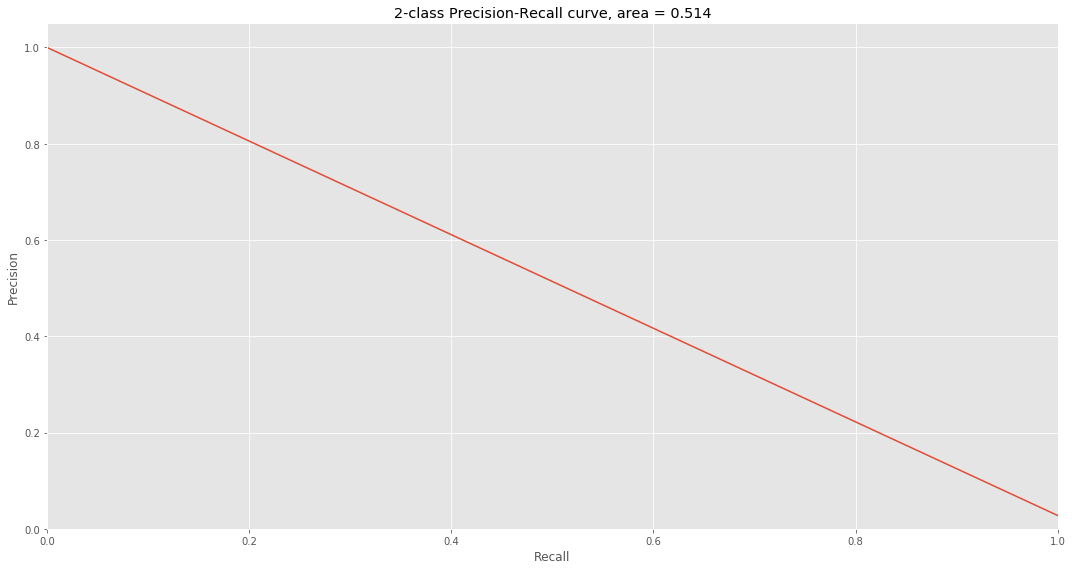

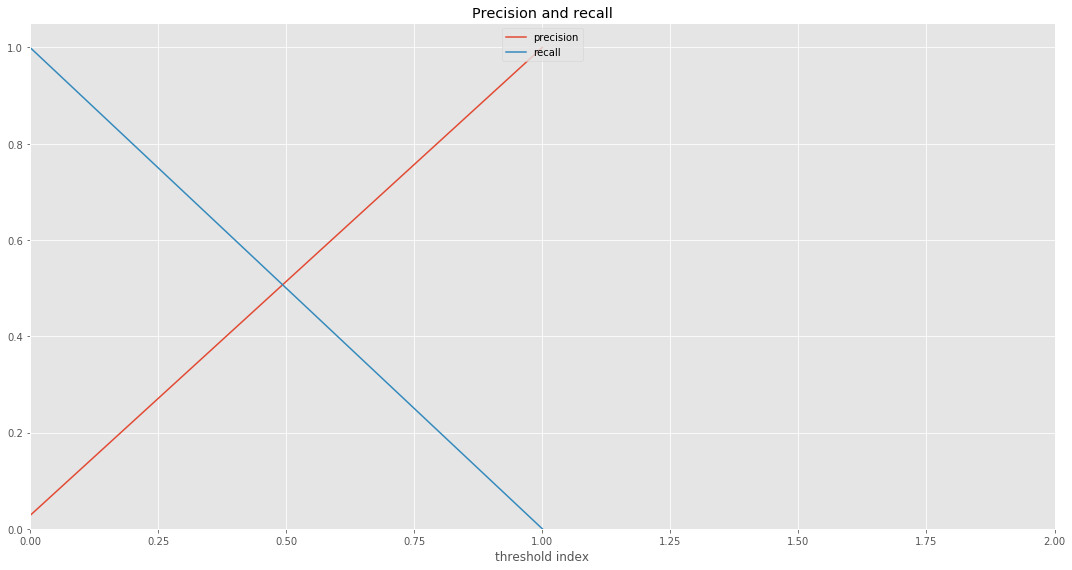

||| PR-curve tresholds: 1, min: 0.99, max: 0.99
||| Area under PR curve = 0.5138371474188398
|| PR and Area calculation: 0.4 seconds
|| Pipeline execution time: 10.9 seconds


In [11]:
truth_and_pred_df, auc, precision, recall, thresholds, execution_time = pipeline.pipeline(
    features=df, 
    labels=labels_all, 
    anomaly_detector="dummy_constant", 
    detector_parameters={"constant_label": 0.99},
    verbose=True,
    scale_data=False
)

|| DummyDetector(strategy='uniform', constant=None, contamination=0.01)
|| scale_data = False
|| Trained detector and scored features: 0.0 seconds
|| Created 1969 segments: 6.4 seconds
|| Created results DataFrame: 4.3 seconds


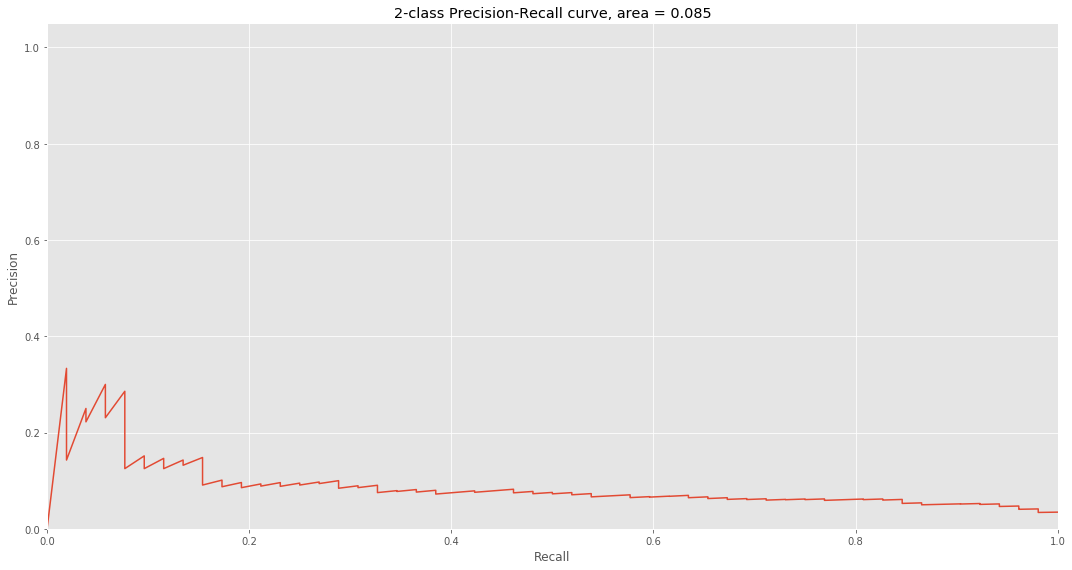

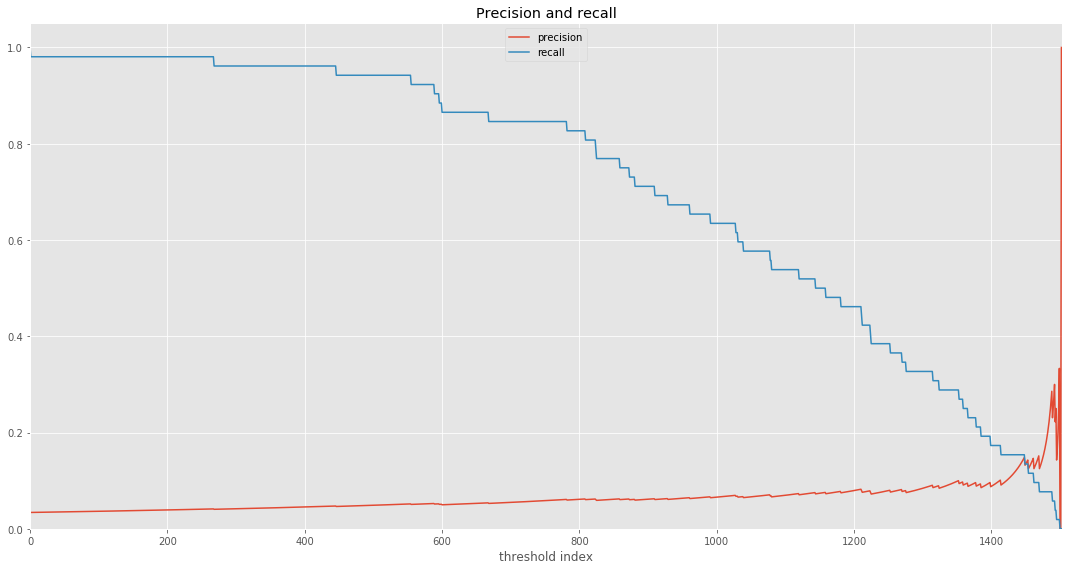

||| PR-curve tresholds: 1502, min: 0.88, max: 1.00
||| Area under PR curve = 0.08512932915741968
|| PR and Area calculation: 0.3 seconds
|| Pipeline execution time: 11.0 seconds


In [12]:
truth_and_pred_df, auc, precision, recall, thresholds, execution_time = pipeline.pipeline(
    features=df, 
    labels=labels_all, 
    anomaly_detector="dummy_uniform", 
    detector_parameters={},
    verbose=True,
    scale_data=False
)
dummy_results["dummy_uniform"] = {
    "precision": precision,
    "recall": recall,
    "auc": auc
}

|| DummyDetector(strategy='stratified', constant=None, contamination=0.01)
|| scale_data = False
|| Trained detector and scored features: 0.0 seconds
|| Created 1969 segments: 6.5 seconds
|| Created results DataFrame: 4.4 seconds


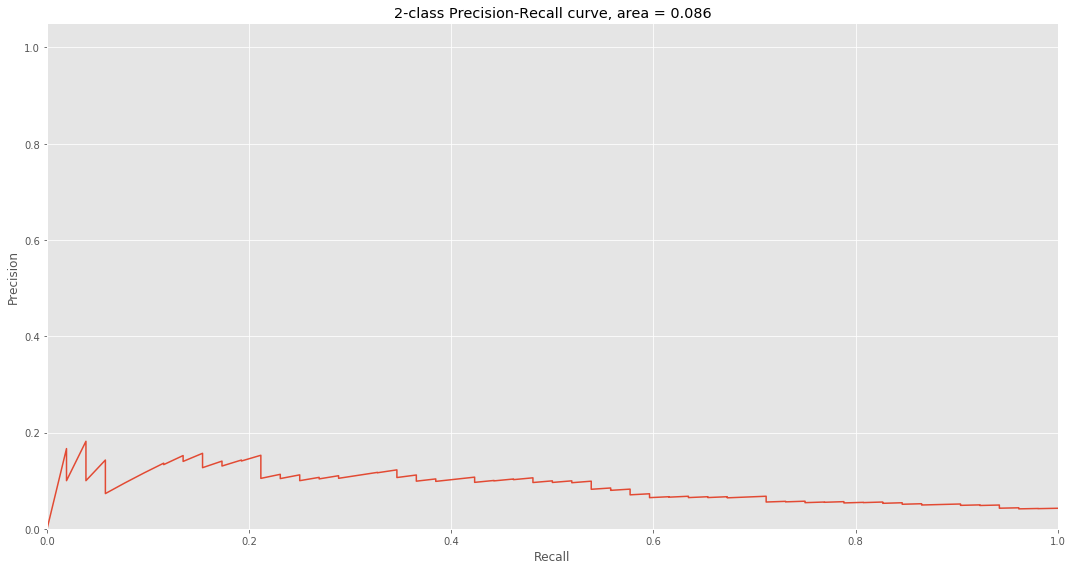

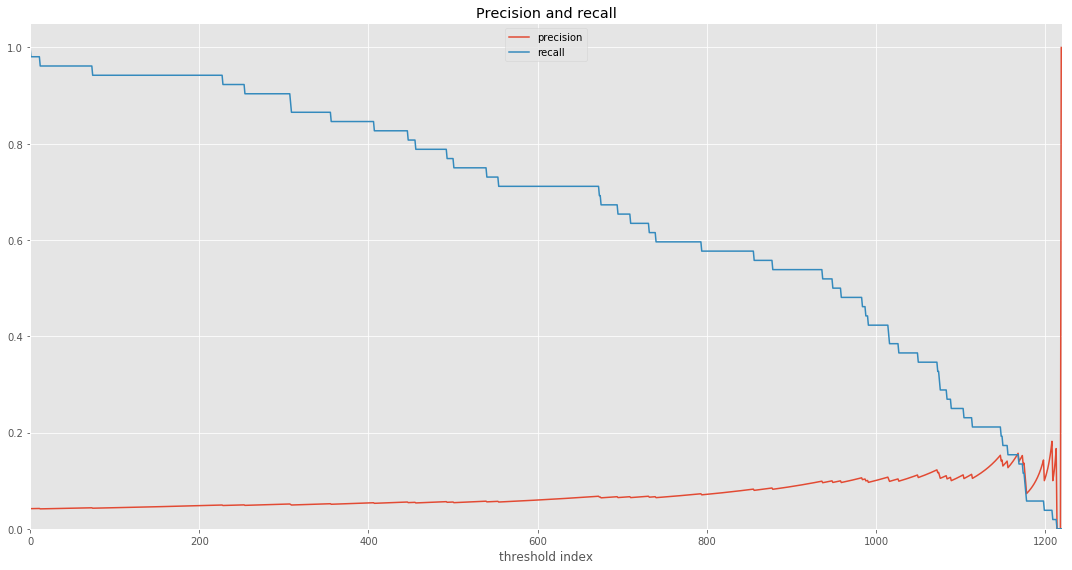

||| PR-curve tresholds: 1219, min: 0.68, max: 1.00
||| Area under PR curve = 0.08633433391957358
|| PR and Area calculation: 0.3 seconds
|| Pipeline execution time: 11.3 seconds


In [13]:
truth_and_pred_df, auc, precision, recall, thresholds, execution_time = pipeline.pipeline(
    features=df, 
    labels=labels_all, 
    anomaly_detector="dummy_stratified", 
    detector_parameters={"contamination": 0.01},
    verbose=True,
    scale_data=False
)
dummy_results["dummy_stratified 0.01"] = {
    "precision": precision,
    "recall": recall,
    "auc": auc
}

|| DummyDetector(strategy='stratified', constant=None, contamination=0.1)
|| scale_data = False
|| Trained detector and scored features: 0.0 seconds
|| Created 1969 segments: 6.5 seconds
|| Created results DataFrame: 4.6 seconds


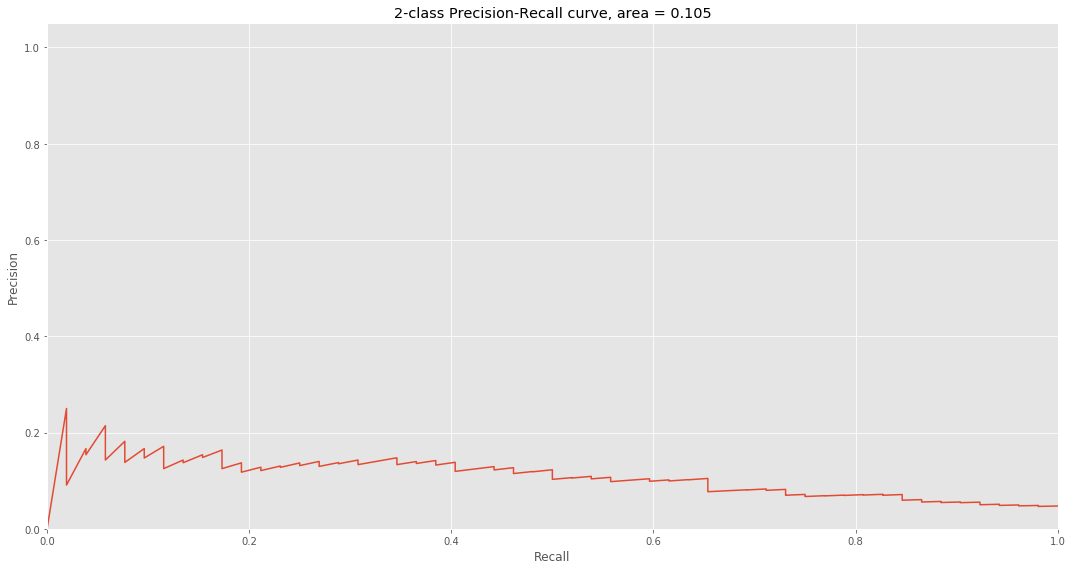

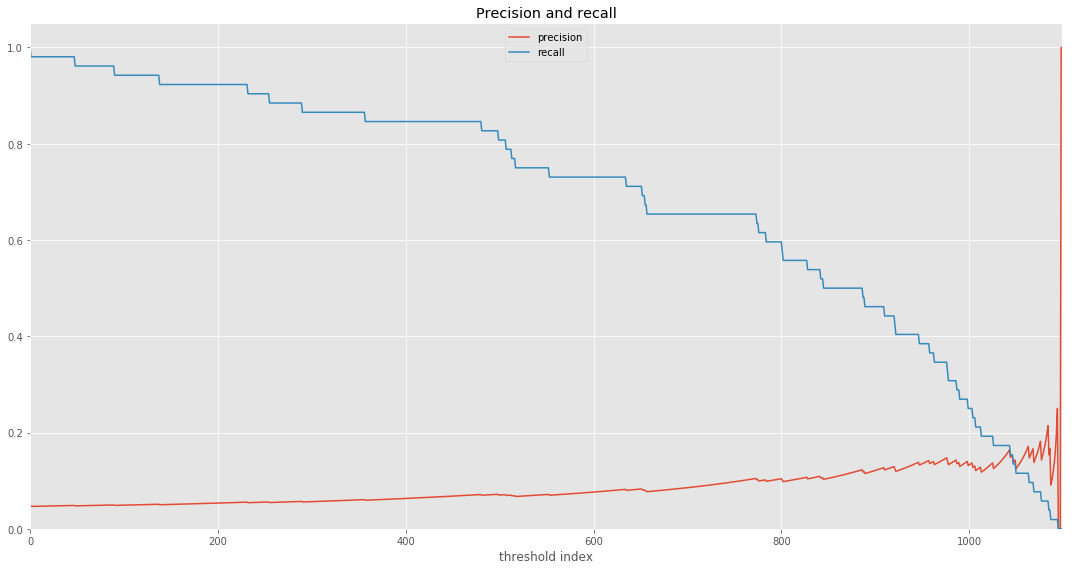

||| PR-curve tresholds: 1098, min: 0.92, max: 1.00
||| Area under PR curve = 0.1054112830836616
|| PR and Area calculation: 0.3 seconds
|| Pipeline execution time: 11.5 seconds


In [14]:
truth_and_pred_df, auc, precision, recall, thresholds, execution_time = pipeline.pipeline(
    features=df, 
    labels=labels_all, 
    anomaly_detector="dummy_stratified", 
    detector_parameters={"contamination": 0.1},
    verbose=True,
    scale_data=False
)
dummy_results["dummy_stratified 0.1"] = {
    "precision": precision,
    "recall": recall,
    "auc": auc
}

|| DummyDetector(strategy='stratified', constant=None, contamination=0.9)
|| scale_data = False
|| Trained detector and scored features: 0.0 seconds
|| Created 1969 segments: 6.5 seconds
|| Created results DataFrame: 4.2 seconds


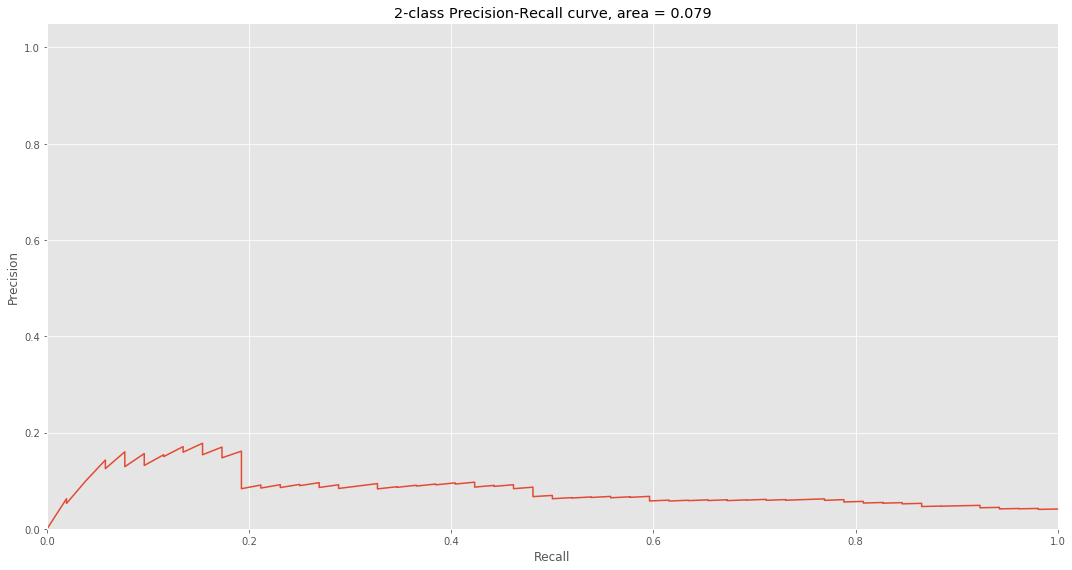

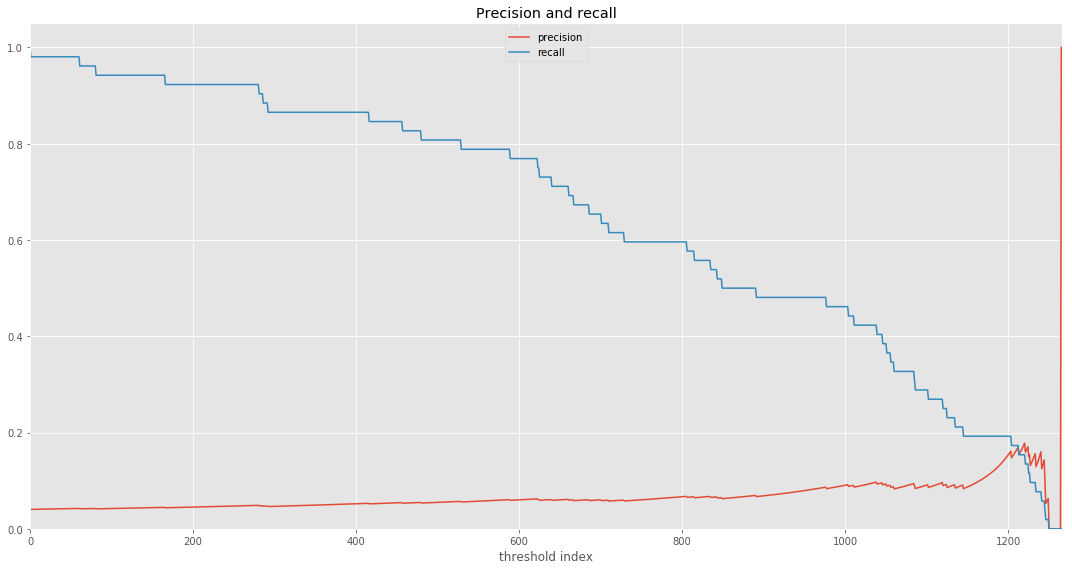

||| PR-curve tresholds: 1265, min: 0.99, max: 1.00
||| Area under PR curve = 0.07905083854011519
|| PR and Area calculation: 0.3 seconds
|| Pipeline execution time: 11.1 seconds


In [15]:
truth_and_pred_df, auc, precision, recall, thresholds, execution_time = pipeline.pipeline(
    features=df, 
    labels=labels_all, 
    anomaly_detector="dummy_stratified", 
    detector_parameters={"contamination": 0.9},
    verbose=True,
    scale_data=False
)
dummy_results["dummy_stratified 0.9"] = {
    "precision": precision,
    "recall": recall,
    "auc": auc
}

In [16]:
dummy_results

{'dummy_stratified 0.01': {'auc': 0.08633433391957358,
  'precision': array([0.04265792, 0.04187192, 0.04190633, ..., 0.        , 0.        ,
         1.        ]),
  'recall': array([1.        , 0.98076923, 0.98076923, ..., 0.        , 0.        ,
         0.        ])},
 'dummy_stratified 0.1': {'auc': 0.1054112830836616,
  'precision': array([0.04735883, 0.04649043, 0.04653285, ..., 0.        , 0.        ,
         1.        ]),
  'recall': array([1.        , 0.98076923, 0.98076923, ..., 0.        , 0.        ,
         0.        ])},
 'dummy_stratified 0.9': {'auc': 0.07905083854011519,
  'precision': array([0.04110672, 0.0403481 , 0.04038005, ..., 0.        , 0.        ,
         1.        ]),
  'recall': array([1.        , 0.98076923, 0.98076923, ..., 0.        , 0.        ,
         0.        ])},
 'dummy_uniform': {'auc': 0.08512932915741968,
  'precision': array([0.03462051, 0.03397735, 0.034     , ..., 0.        , 0.        ,
         1.        ]),
  'recall': array([1.      

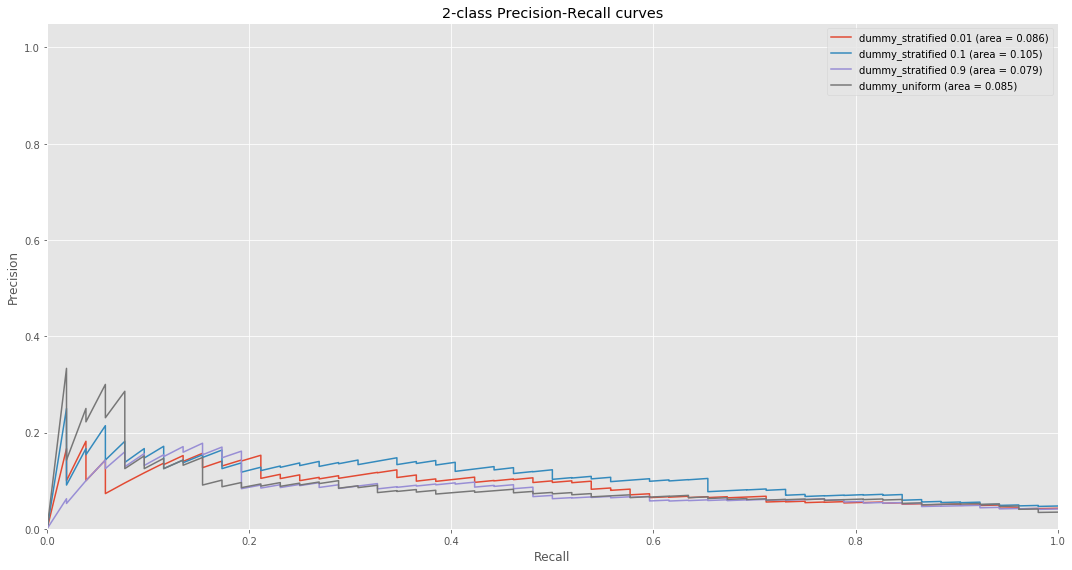

In [17]:
plot.evaluation.plot_pr_curves_named(dummy_results)